In [317]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
import sys
sys.path.append("../")

from historical.readData.estimateData3 import read

from historical.readData.estimateData3 import read
from historical.readData.estimateData3 import search_travels
from historical.readData.estimateData3 import estimate
from historical.readData.estimateData3 import stops_distance

from historical.readData.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

In [318]:
# if __name__ == '__main__':

selected_line = ['8700-10-1']

# '8700-10-0',
# selected_line = ['8700-10-1',                
#                 '7545-10-1',
#                 '7545-10-0',
#                 '6450-10-1',
#                 '6450-10-0',
#                 '3301-10-1',
# #                 '3301-10-0',
#                 '2290-10-1',
#                 '2290-10-0',
# #                 '574J-10-1',
# #                 '574J-10-0',
# #                 '477P-10-1',
#                 '477P-10-0',
# #                 '351F-10-1',
# #                 '351F-10-0'
#                 ]

In [319]:
pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']


In [320]:
line = selected_line[0]
pth_files_lines = "../historical/readData/"
p, mp = stops_distance(line)
df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")   
df_temporal = df.loc[(df['day'] >=  np.datetime64('2017-09-01'))]

  

In [321]:
import dateutil
import datetime 

segtime_mp = [pd.DataFrame(columns=range(len(mp) - 1))]
df_temporal

,car,numtravel,day,weekday,holiday,start,travel_time,distance,time,period
4060695,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.04275,0.000000,morning
4060696,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.18901,3.966667,morning
4060697,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.26396,4.716667,morning
4060698,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.37055,4.900000,morning
4060699,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.53848,5.650000,morning
4060700,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.57871,5.733333,morning
4060701,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.81860,6.100000,morning
4060702,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,0.93588,6.716667,morning
4060703,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,1.13149,7.466667,morning
4060704,81907\r,37446,2017-09-01,4,0,06:40:57,61.866667,1.16372,8.216667,morning


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


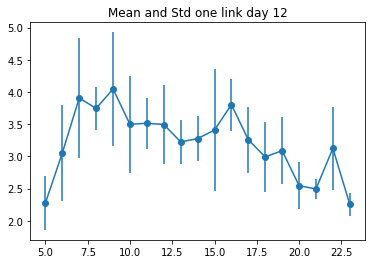

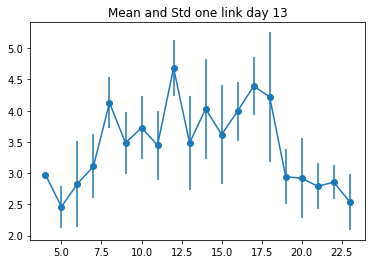

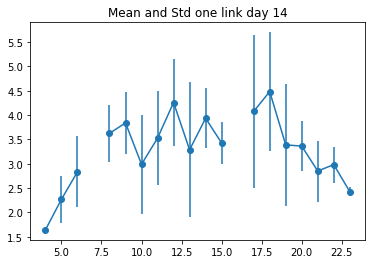

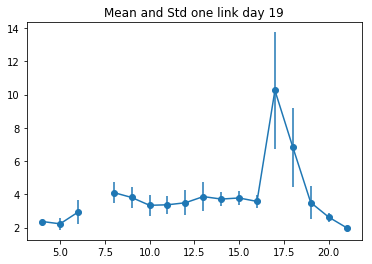

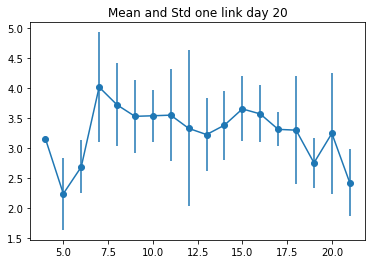

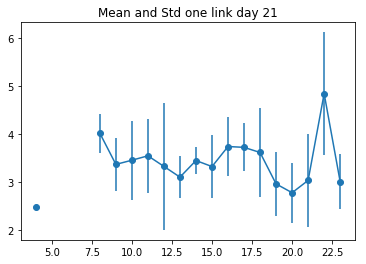

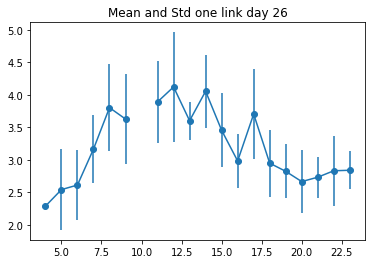

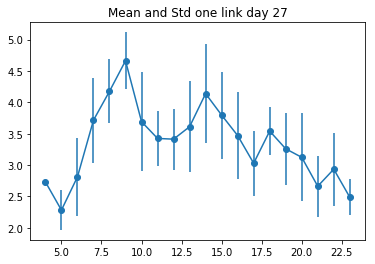

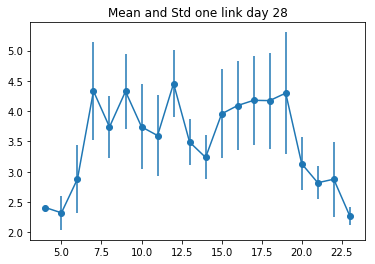

In [322]:
days = [12, 13, 14, 19, 20, 21, 26, 27, 28]
for day_period in days:
    day_temp  = df_temporal.loc[(df_temporal['day'] ==  np.datetime64('2017-09-' + 
          (str(day_period)) if day_period > 10 else  str(day_period)))] 
    
    mean_link = []
    std_link = []
    mean_link_after = []
    std_link_after = []
    
    for period in range(0, 24):
        request_travels = day_temp.loc[(day_temp['start'] >=  dateutil.parser.parse('0' + str(period) + ':00:00').time()) & 
                      (day_temp['start'] <=  dateutil.parser.parse('0' + str(period) + ':59:00').time())]

        travels = sorted(list(set(request_travels['numtravel'])))
        est_mp = estimate(mp, reps, travels)

        link_df = []
        link_df_after = []
        for tr in travels:

            tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
            row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
            d = pd.DataFrame(row, columns=range(len(mp)-1))
            link_df.append(d[0])
            link_df_after.append(d[1])

        mean_link.append(np.mean(link_df))
        std_link.append(np.std(link_df))
        mean_link_after.append(np.mean(link_df_after))
        std_link_after.append(np.std(link_df_after))
        
    
    # example data
    x = range(0,len(mean_link))
    # example error bar values that vary with x-position

    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    ax0.errorbar(x, mean_link, yerr=std_link, fmt='-o')
    ax0.set_title('Mean and Std one link day ' + str(day_period))
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


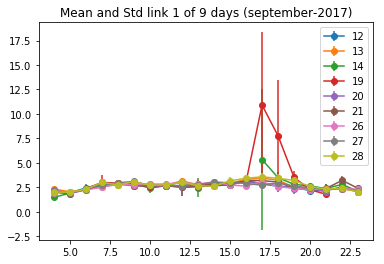

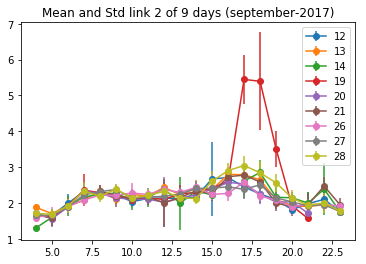

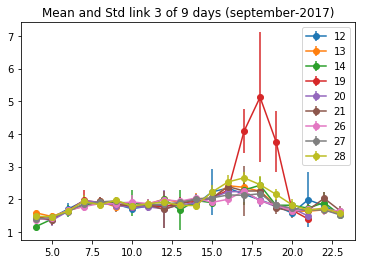

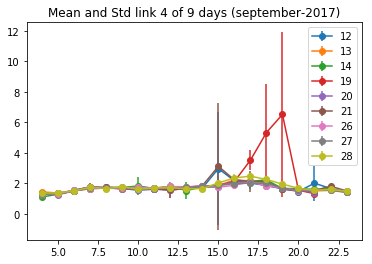

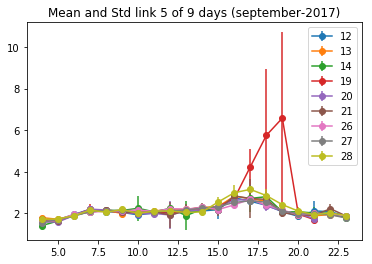

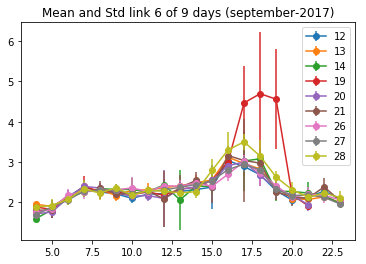

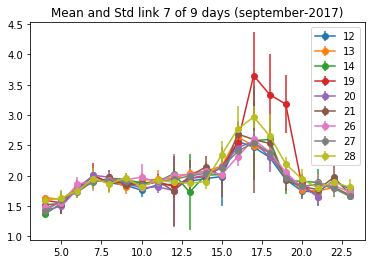

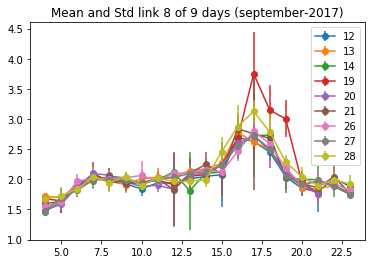

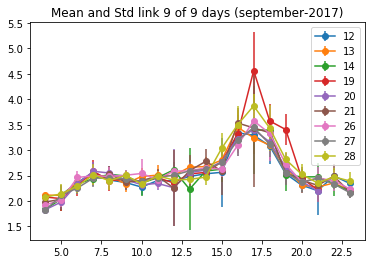

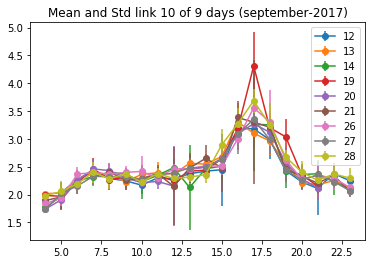

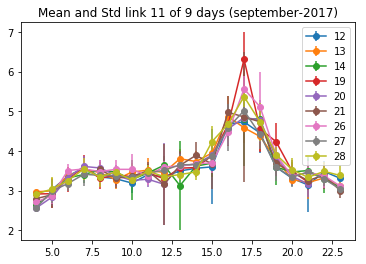

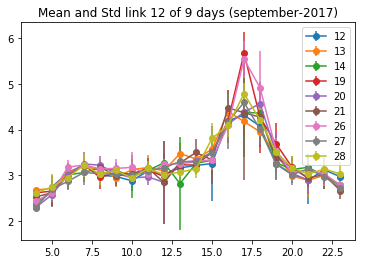

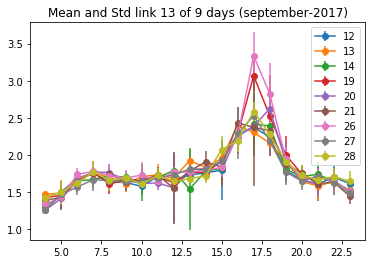

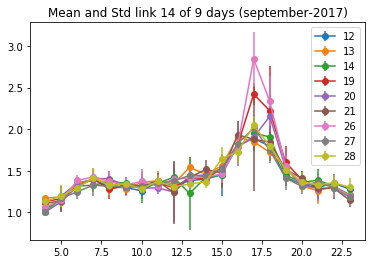

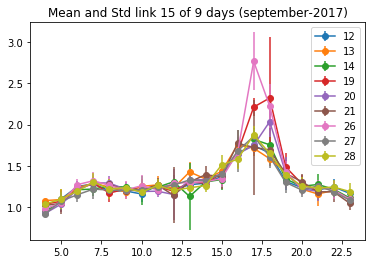

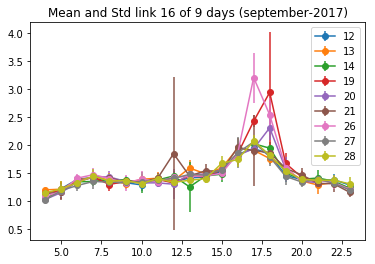

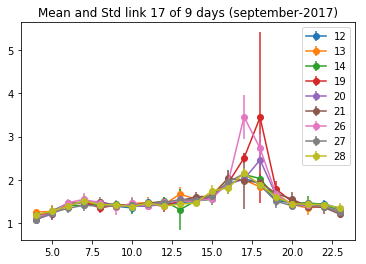

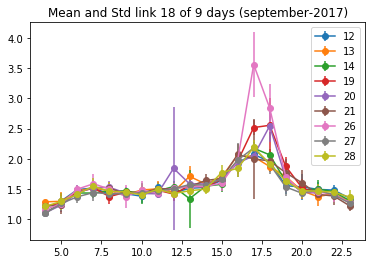

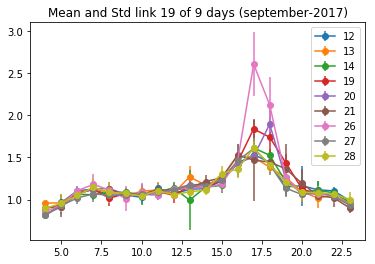

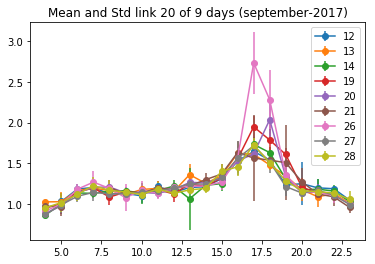

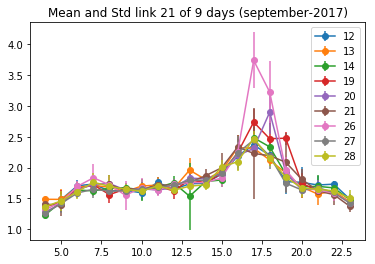

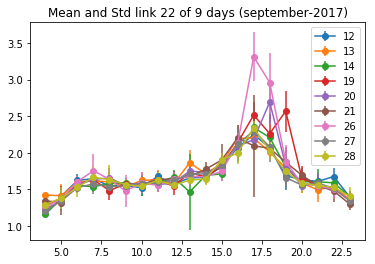

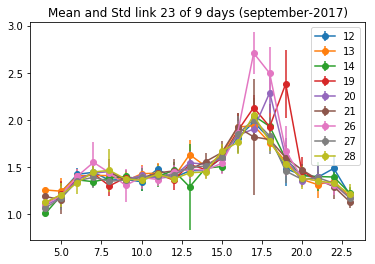

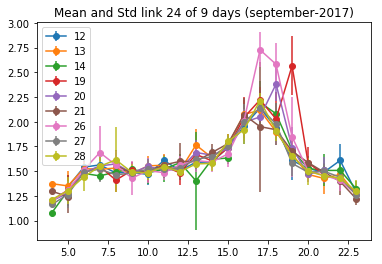

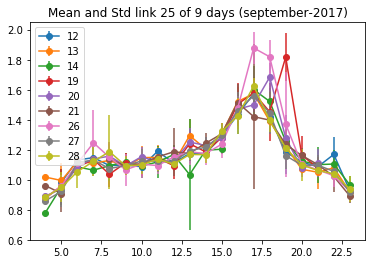

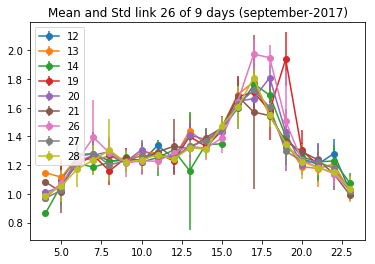

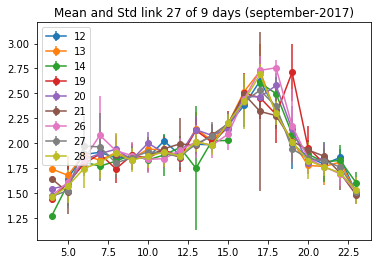

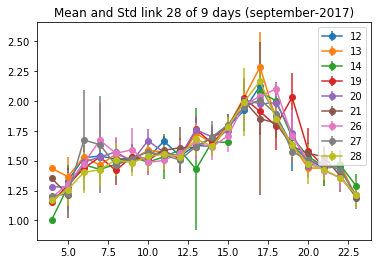

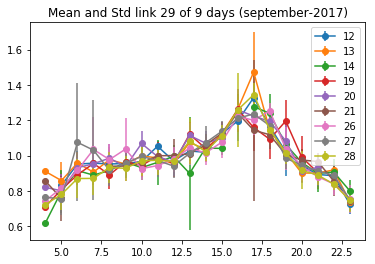

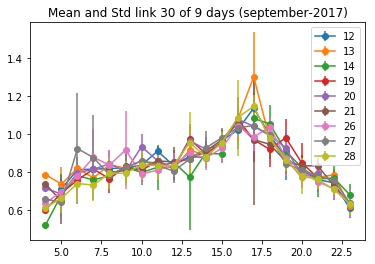

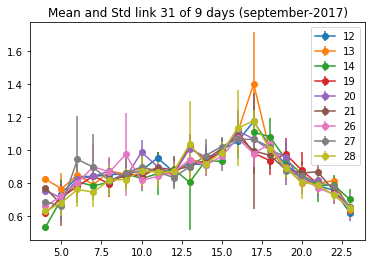

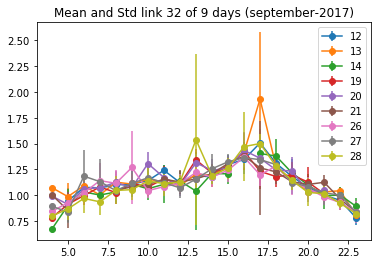

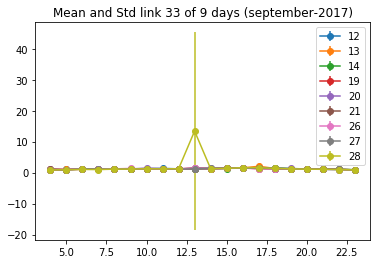

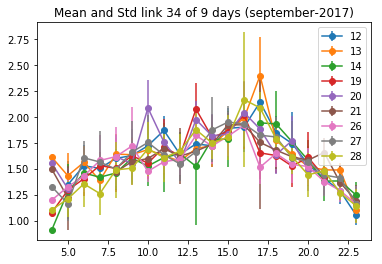

KeyError: 36

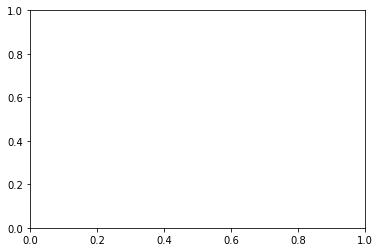

In [323]:
for link_line in range(1, 35):
    days = [12, 13, 14, 19, 20, 21, 26, 27, 28]
    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    for day_period in days:
        day_temp  = df_temporal.loc[(df_temporal['day'] ==  np.datetime64('2017-09-' + 
              (str(day_period)) if day_period > 10 else  str(day_period)))] 


        mean_link = []
        std_link = []
        mean_link_after = []
        std_link_after = []

        for period in range(0, 24):
            request_travels = day_temp.loc[(day_temp['start'] >=  dateutil.parser.parse('0' + str(period) + ':00:00').time()) & 
                          (day_temp['start'] <=  dateutil.parser.parse('0' + str(period) + ':59:00').time())]

            travels = sorted(list(set(request_travels['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df = []
            link_df_after = []
            for tr in travels:

                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))

                link_df.append(d[link_line])
                link_df_after.append(d[link_line+1])

            mean_link.append(np.mean(link_df))
            std_link.append(np.std(link_df))
            mean_link_after.append(np.mean(link_df_after))
            std_link_after.append(np.std(link_df_after))


        # example data
        x = range(0,len(mean_link))
        # example error bar values that vary with x-position


        ax0.errorbar(x, mean_link, yerr=std_link, fmt='-o')
    ax0.set_title('Mean and Std link ' + str(link_line) + ' of 9 days (september-2017)')
    ax0.legend(days)
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


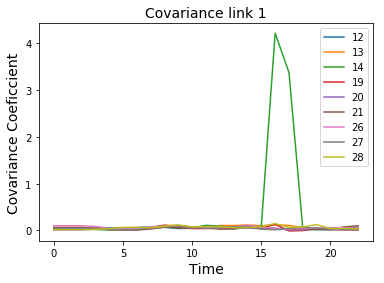

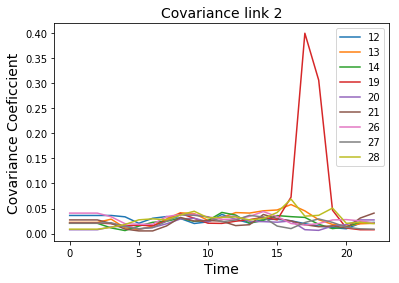

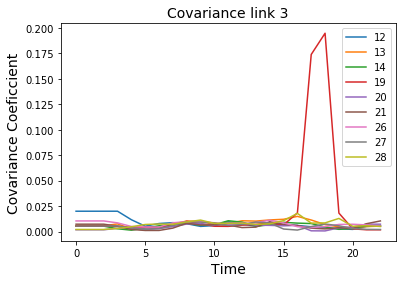

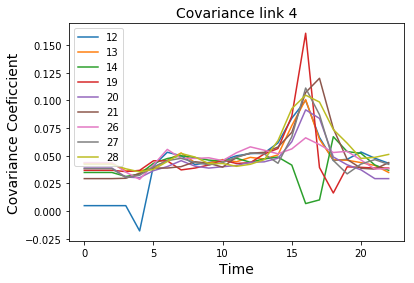

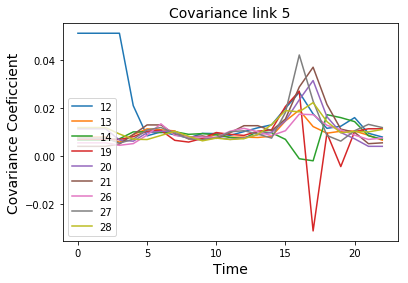

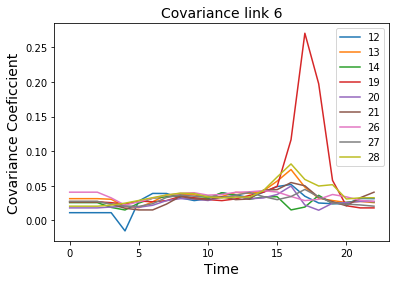

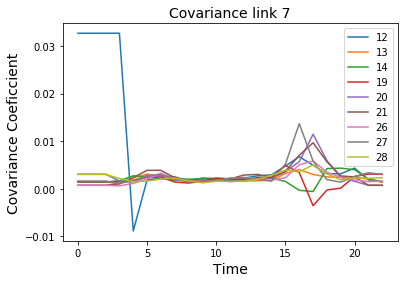

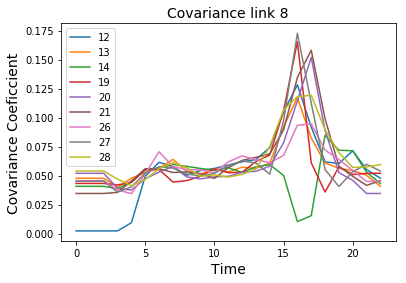

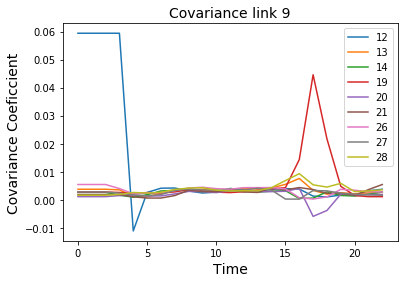

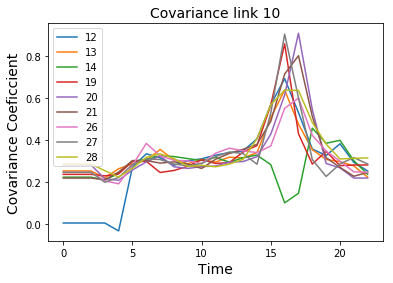

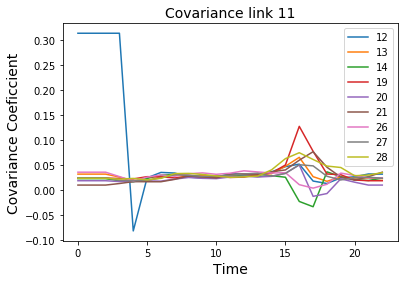

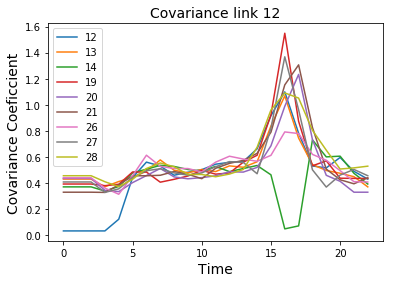

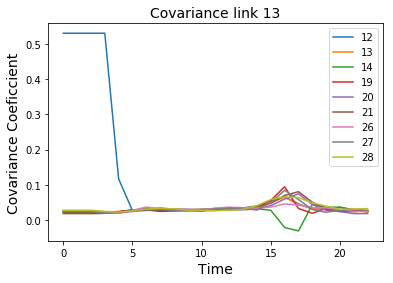

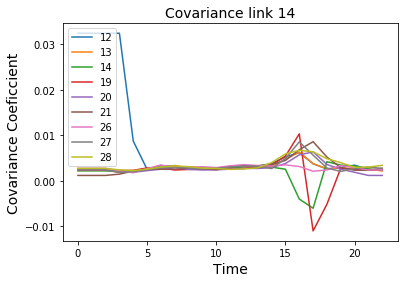

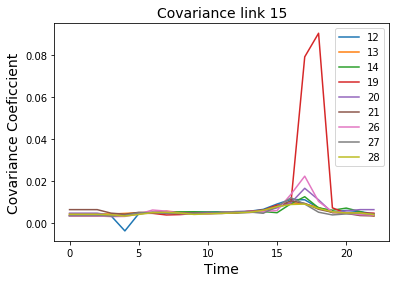

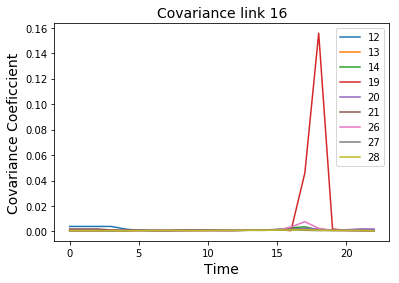

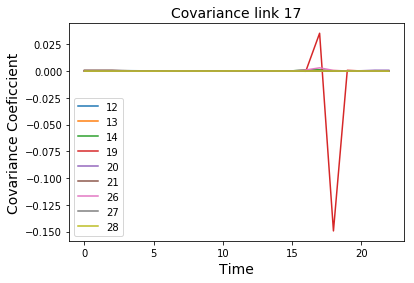

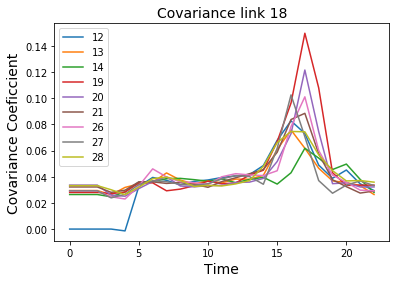

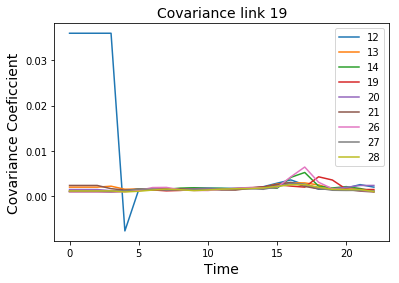

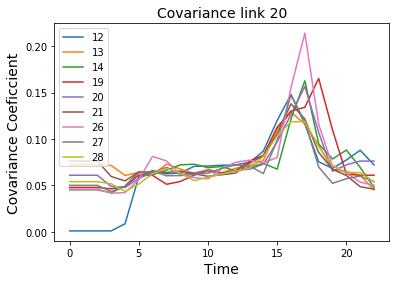

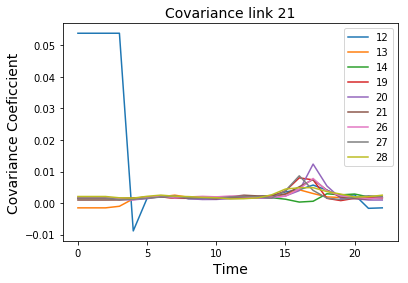

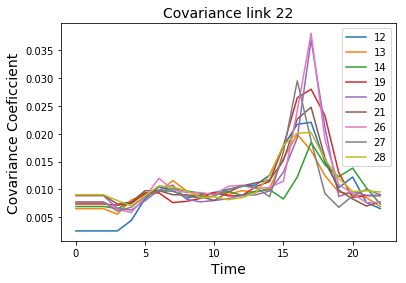

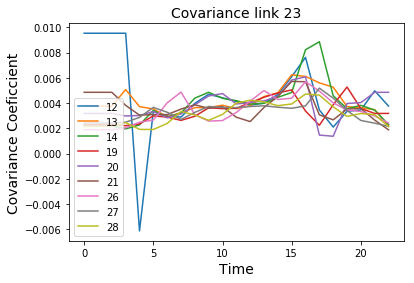

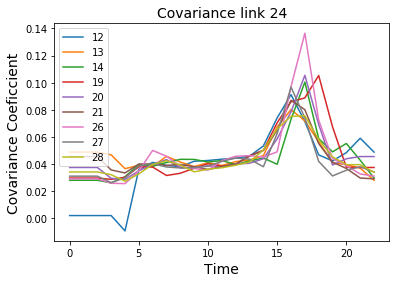

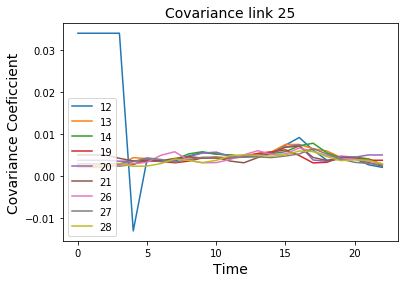

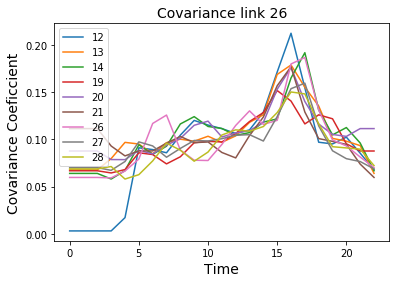

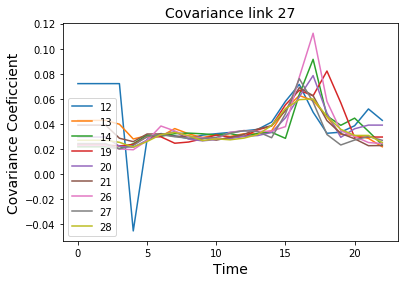

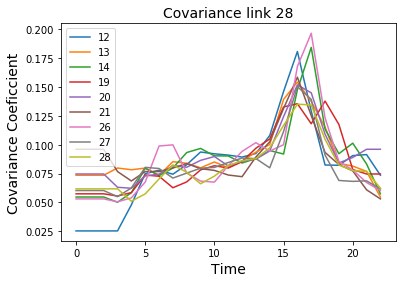

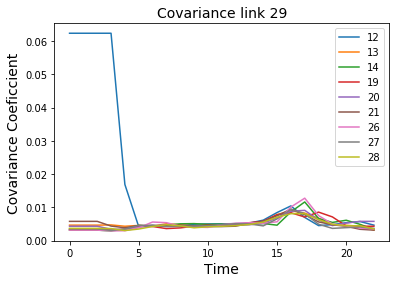

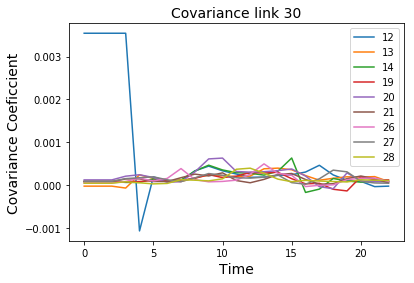

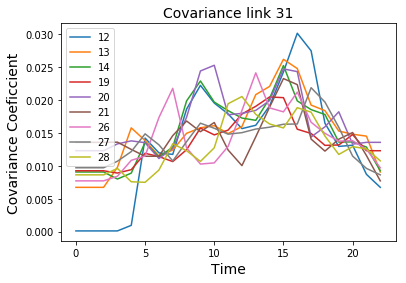

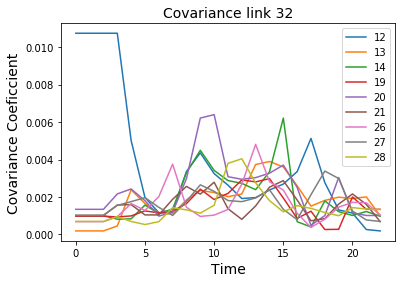

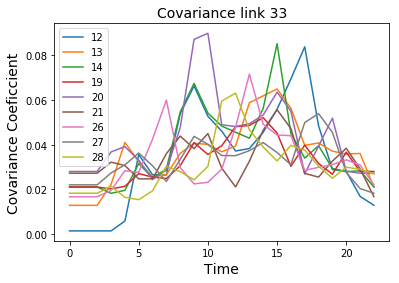

In [ ]:
for link_line in range(1, 35):
    days = [12, 13, 14, 19, 20, 21, 26, 27, 28]
    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    for day_period in days:
        day_temp  = df_temporal.loc[(df_temporal['day'] ==  np.datetime64('2017-09-' + 
              (str(day_period)) if day_period > 10 else  str(day_period)))] 

        mean_link = []
        std_link = []
        mean_link_after = []
        std_link_after = []
        cov_link = []
        for period_hour in range(0, 23):
            request_travels_1 = day_temp.loc[(day_temp['start'] >=  dateutil.parser.parse('0' + str(period_hour) + ':00:00').time()) & 
                          (day_temp['start'] <=  dateutil.parser.parse('0' + str(period_hour) + ':59:00').time())]

            travels = sorted(list(set(request_travels_1['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df_1 = []
            link_df_after_1 = []
            for tr in travels:
                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))
                link_df_1.append(float(d[link_line]))
                link_df_after_1.append(float(d[link_line + 1]))                
                a = [float(d[link_line]), float(d[link_line + 1])]                
                
            request_travels_2 = day_temp.loc[(day_temp['start'] >=  dateutil.parser.parse('0' + str(period_hour + 1) + ':00:00').time()) & 
                          (day_temp['start'] <=  dateutil.parser.parse('0' + str(period_hour + 1) + ':59:00').time())]

            travels = sorted(list(set(request_travels_2['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df_2 = []
            link_df_after_2 = []
            for tr in travels:

                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))
                link_df_2.append(float(d[link_line]))
                link_df_after_2.append(float(d[link_line + 1]))
                b = [float(d[link_line]), float(d[link_line + 1])]

            mean_link.append(np.mean(link_df_1))
            std_link.append(np.std(link_df_1))
            mean_link_after.append(np.mean(link_df_after_2))
            std_link_after.append(np.std(link_df_after_2))
            cov_link.append(np.cov(a, b, bias=True)[0][1])
            
        plt.plot(cov_link)
    plt.title('Covariance link ' + str(link_line),fontsize=14)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Covariance Coeficcient',fontsize=14)
    plt.legend(days)
    plt.show()
